<div style='background-image: url("../share/Aerial_view_LLNL.jpg") ; padding: 0px ; background-size: cover ; border-radius: 15px ; height: 250px; background-position: 0% 80%'>
    <div style="float: right ; margin: 50px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.8) ; width: 50% ; height: 150px">
        <div style="position: relative ; top: 50% ; transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.9) ; line-height: 100%">Comparison of SW4 Synthetics
           </div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.7)">Observed vs Synthetic Data</div>
        </div>
    </div>
</div>

### **2017 CIG-LLNL Computational Seismology Workshop**


##### Authors:

* Lion Krischer ([@krischer](https://github.com/krischer))

---

In [1]:
%matplotlib inline
from __future__ import print_function
import matplotlib.pyplot as plt

import numpy as np
import os

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 12, 8

### Observed Data

For SW4 we'll work with the Piedmont (near Oakland and Berkeley) Mw 4.2 event from 2007/07/20. So the first step is to find information about the event as well as stations and waveforms.

Depending on which earthquakes you simulated in the previous days you might have to adjust this slightly.

In [2]:
# Approximate coordinates of Berkeley to be able to find the event.
berkley_lon_lat = (-122.272747, 37.8715926)

#### Event Data

Let's find the event via the USGS web service.

1 Event(s) in Catalog:
2007-07-20T11:42:22.360000Z | +37.804, -122.193 | 4.2 mw | manual


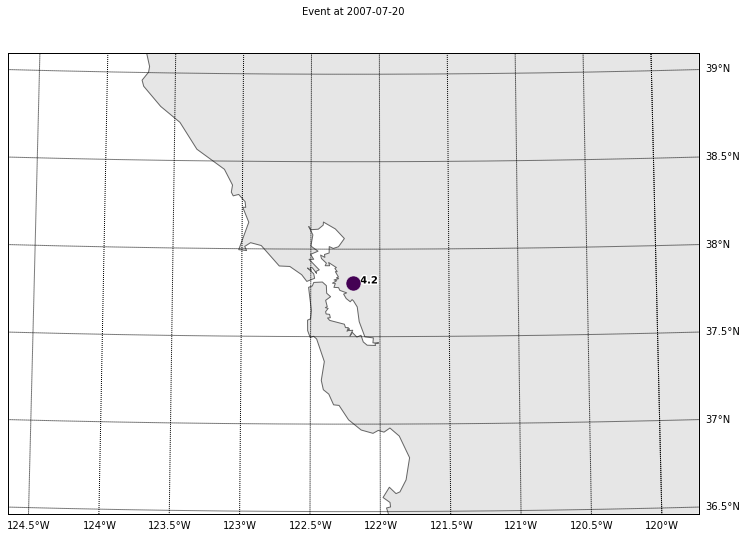

In [3]:
import obspy
from obspy.clients.fdsn import Client


c_usgs = Client("USGS")
cat = c_usgs.get_events(
    # Earthquake happened on the July 20th, 2007
    starttime=obspy.UTCDateTime(2007, 7, 20),
    endtime=obspy.UTCDateTime(2007, 7, 21),
    # Close to Berkeley
    longitude=berkley_lon_lat[0],
    latitude=berkley_lon_lat[1],
    maxradius=1,
    # magnitude of 4.2
    minmagnitude=4)

# Print and plot event.
print(cat)
cat.plot(projection="local", resolution="i");

#### Station Data

We also need information about the stations.

In [4]:
# The folder with the backup synthetic data has SW4
# synthetics for three scenarios. Each has slightly
# different stations, the following ten stations
# are available for each scenario.
# All in the BK network.
stations = ["BDM", "BKS", "BRIB", "BRK", "CVS",
            "MHC", "MNRC", "PACP", "SAO", "WENL"]

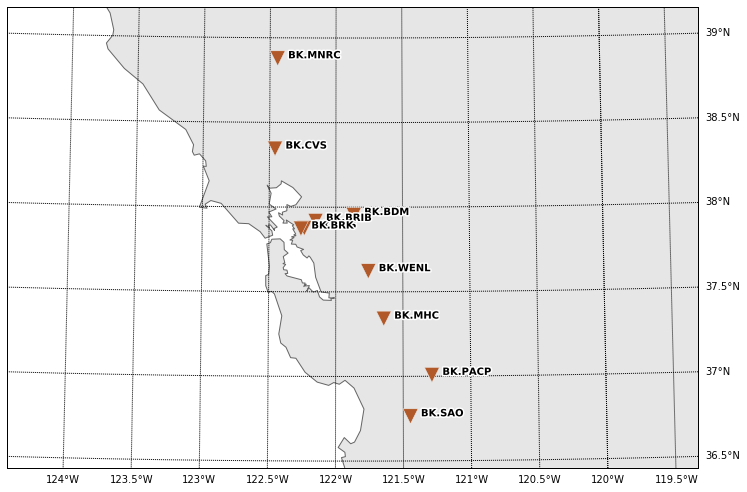

In [5]:
# Get the inventory data for 
c_ncedc = Client("NCEDC")
inv = c_ncedc.get_stations(
    network="BK",
    station=",".join(stations),
    # Make sure stations are active at the time of the recording.
    starttime=obspy.UTCDateTime(2007, 7, 20),
    endtime=obspy.UTCDateTime(2007, 7, 21),
    # Also request the response as we'll later use it
    # to remove the instrument response from the observed
    # data.
    level="response")
inv.plot(projection="local", resolution="i");

#### Waveform Data

Last but not least we also the actual observed waveforms to be able to make the comparision.

In [6]:
event_time = cat[0].origins[0].time

# Also download waveform data.
st = c_ncedc.get_waveforms(
    network="BK",
    station=",".join(stations),
    location="*",
    channel="BH?",
    # 5 minutes before to 15 minutes after event.
    starttime=event_time - 5 * 60,
    endtime=event_time + 15 * 60)

### Comparing SW4 Synthetics with Observed Data

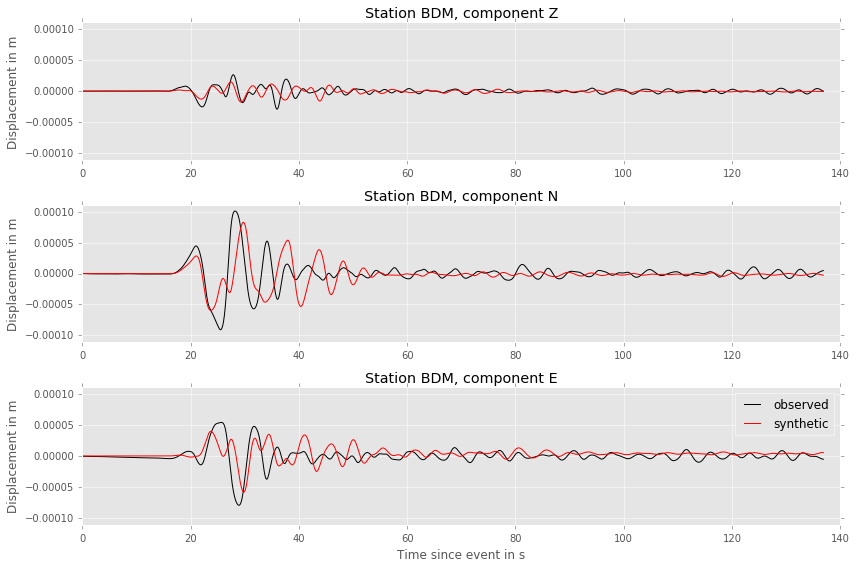

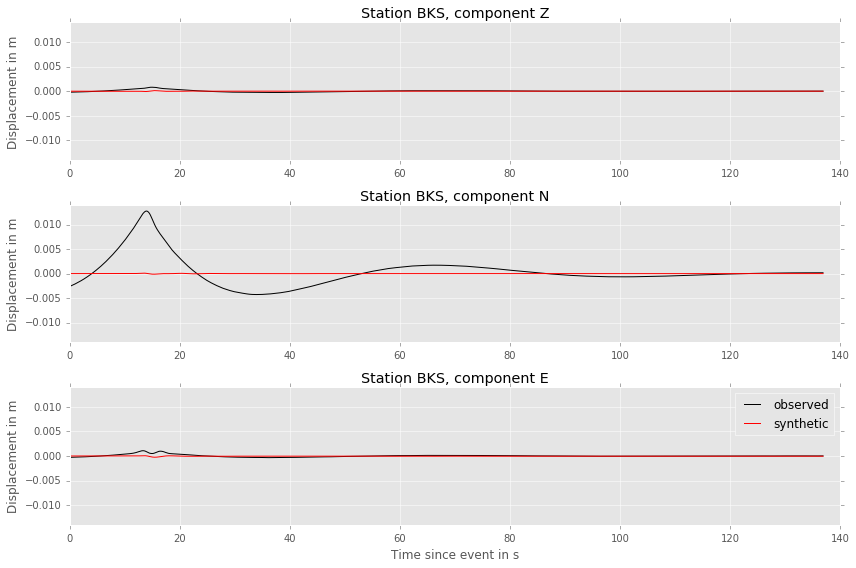

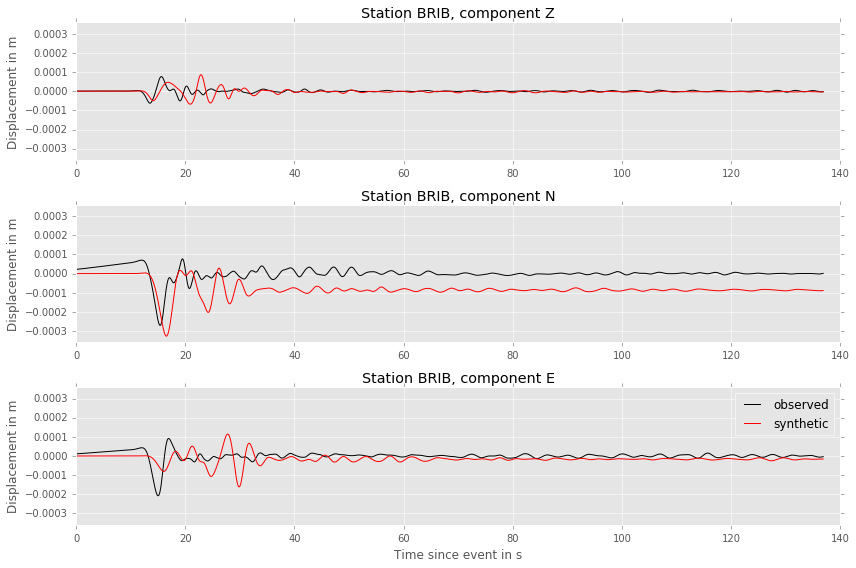

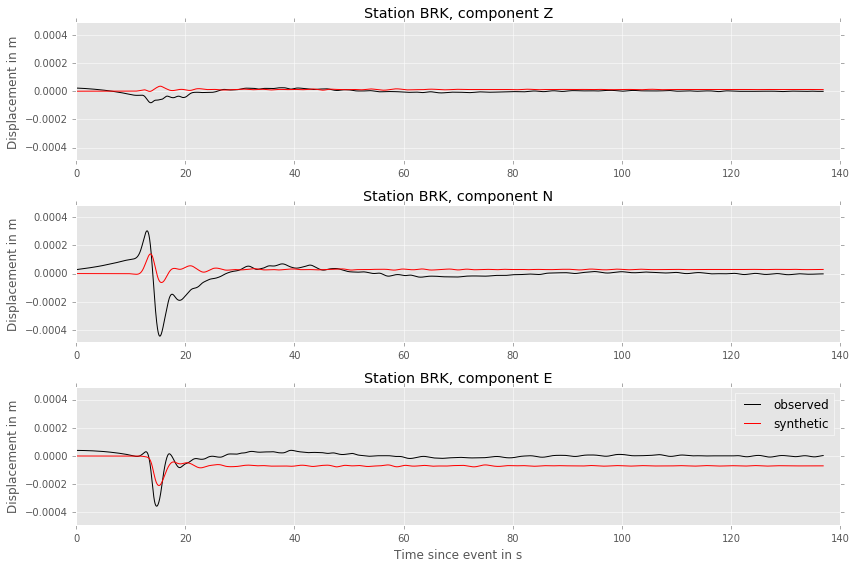

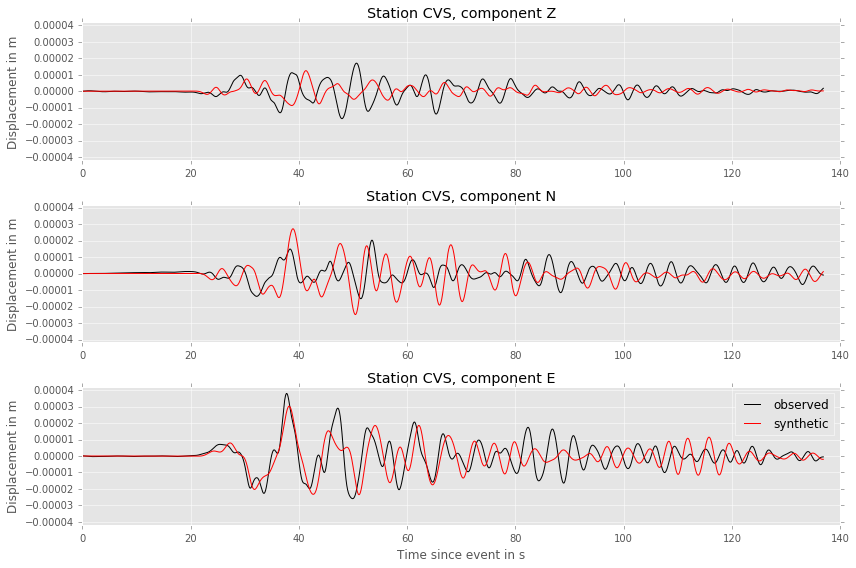

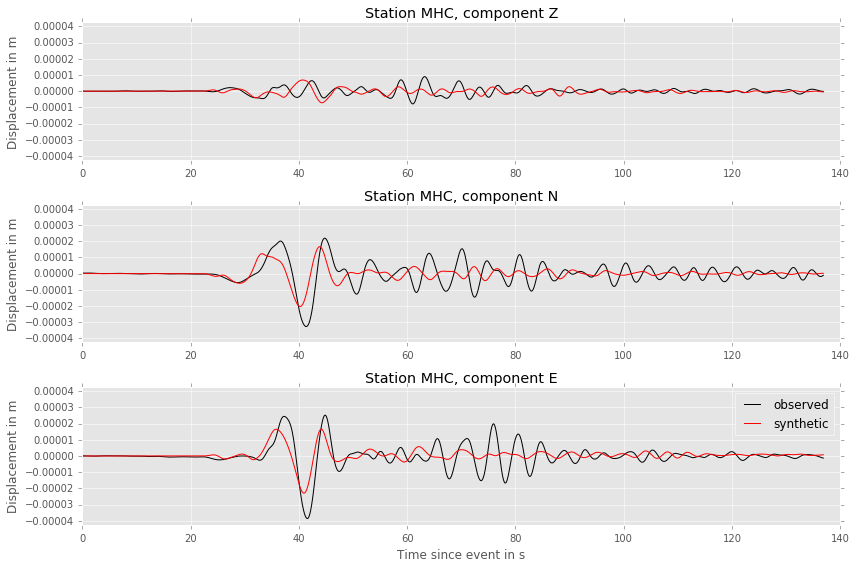

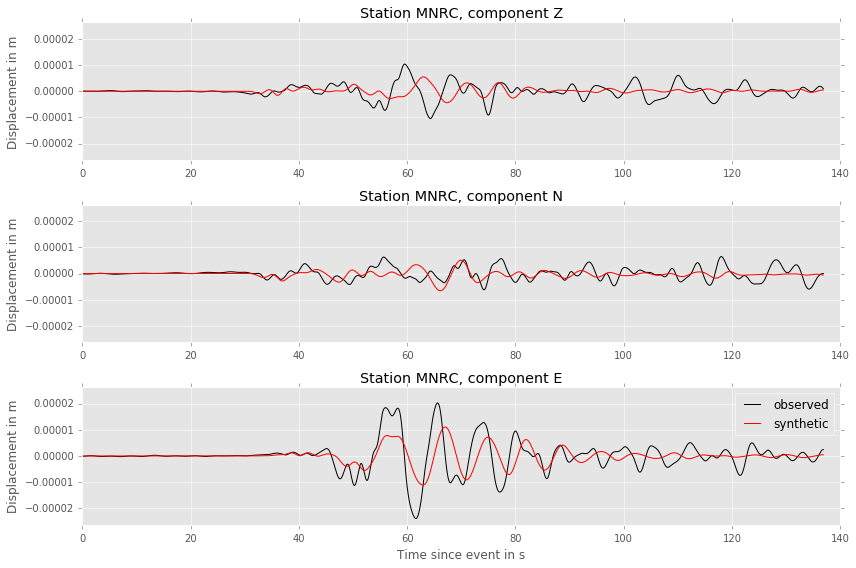

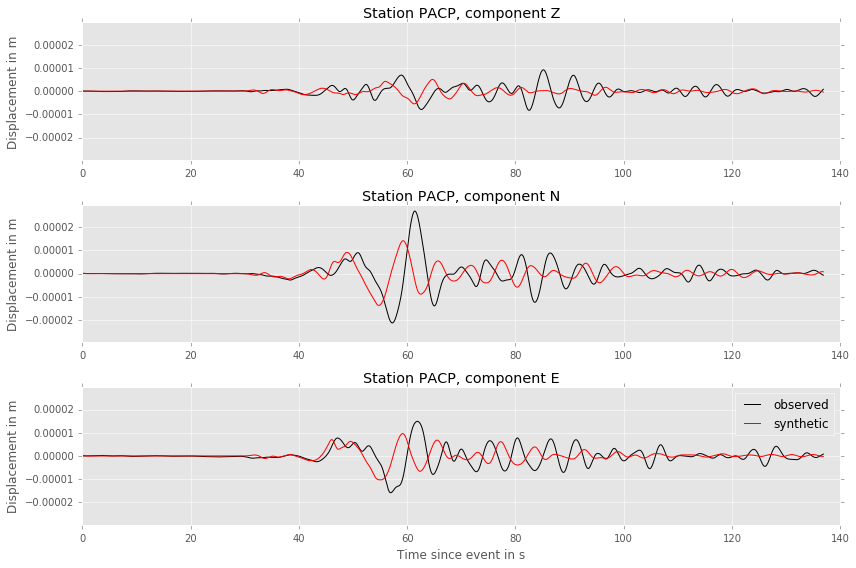

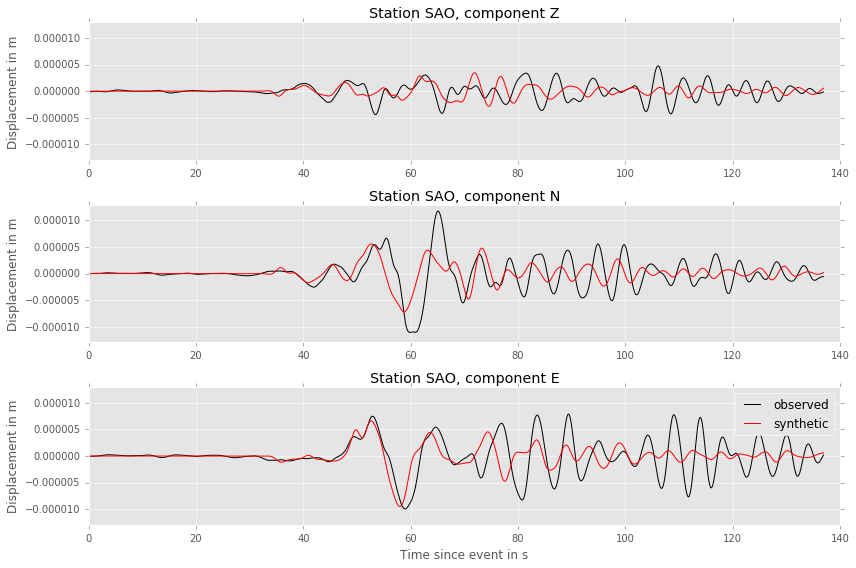

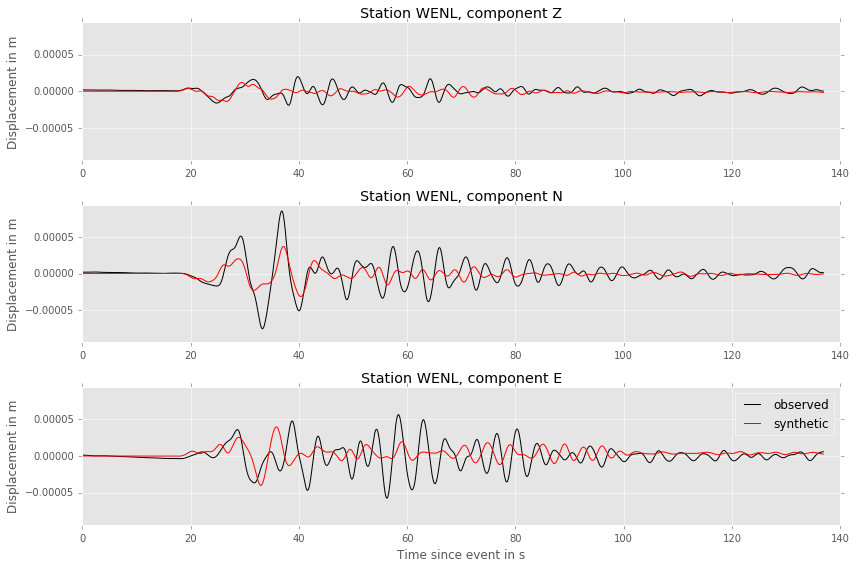

In [7]:
import os

# We'll encapsulate this in a small function to make it easier
# to try out for different stations.
def compare_data_and_synthetics(station, simulation_scenario):
    
    # Sanity check.
    simulation_scenario = simulation_scenario.lower()
    if simulation_scenario not in ("1d", "3d", "3dtopo"):
        raise ValueError("Invalid Scenario.")
        
    # Find the synthetics.
    folder_map = {
        "1d": "../SyntheticData/SW4/PIEDMONT_1D/",
        "3d": "../SyntheticData/SW4/PIEDMONT_3D/",
        "3dtopo": "../SyntheticData/SW4/PIEDMONT_3D_TOPO/",
    }
    files = os.path.join(folder_map[simulation_scenario],
                         "BK.%s.[enu]" % station)
    
    # Read them.
    st_syn = obspy.read(files)
    assert st_syn
    
    # Fix them a bit - network code should not be in the station
    # field, and channel codes should correspond to the
    # FDSN schema.
    for tr in st_syn:
        tr.stats.network = "BK"
        tr.stats.station = tr.stats.station.split(".")[-1]
        tr.stats.channel = {"UP": "XHZ",
                            "NS": "XHN",
                            "EW": "XHE"}[tr.stats.channel]
        
        # Also assume the event time is time zero.
        tr.stats.starttime = event_time - tr.stats.sac.o
 
    # Now we'll get to the interesting part.
    st_obs = st.select(station=station).copy()
    if not st_obs:
        print("Could not find observed data for station %s." % station)
        return
    
    st_obs.detrend("linear")
    st_obs.taper(max_percentage=0.05)
    st_obs.remove_response(
        inventory=inv, output="DISP",
        # Make sure to not touch the frequency band of interest.
        pre_filt=(1.0 / 100.0, 1.0 / 50.0, 2.0, 4.0))
    # Same filter as SW4 applies to the source time function.
    st_obs.filter("lowpass",
                  freq=0.3125,
                  corners=2, zerophase=True)
    # Force continuity - fixed in latest ObsPy master.
    for tr in st_obs:
        tr.data = np.require(tr.data, requirements=["C_CONTIGUOUS"])
    # Now be lazy and upsample to the sample points of the synthetics.
    # This has also no aliasing problems!
    st_obs.interpolate(
        sampling_rate=st_syn[0].stats.sampling_rate,
        # sinc based reconstruction filter.
        method="lanczos", a=12,
        starttime=st_syn[0].stats.starttime,
        npts=st_syn[0].stats.npts)
    
    # Get bounds for plot.
    vmax = max([np.abs(tr.data).max()
                for tr in st_obs + st_syn]) * 1.1
    
    # Plot every channel.
    for _i, c in enumerate(["Z", "N", "E"]):
        plt.subplot(3, 1, _i + 1)
        plt.title("Station %s, component %s" % (station, c))
        tr_obs = st_obs.select(component=c)[0]
        tr_syn = st_syn.select(component=c)[0]
        plt.plot(tr_obs.times(), tr_obs.data, color="black",
                 label="observed")
        plt.plot(tr_syn.times(), tr_syn.data, color="red",
                 label="synthetic")
        plt.ylim(-vmax, vmax)
        plt.ylabel("Displacement in m")
    plt.xlabel("Time since event in s")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
for s in stations:
    compare_data_and_synthetics(station=s,
                                simulation_scenario="3dtopo")